# 1. Equations of state

<img style = "float: left;" src = "slides/1a_VdW.png" width = "80%">
<img style = "float: left;" src = "slides/1b_Cubic.png" width = "80%">

## 1.1. PVT behaviour of CO$_2$
In this section, we will have a look at the PVT relationship for CO2 as described by a cubic EoS.

Rather than (P,T), the EoS is explicitly expressed in terms of P(T,V).

VT props progress: finished0 idxs: [999   3] state: [0.0021, 313.0, 1.0]


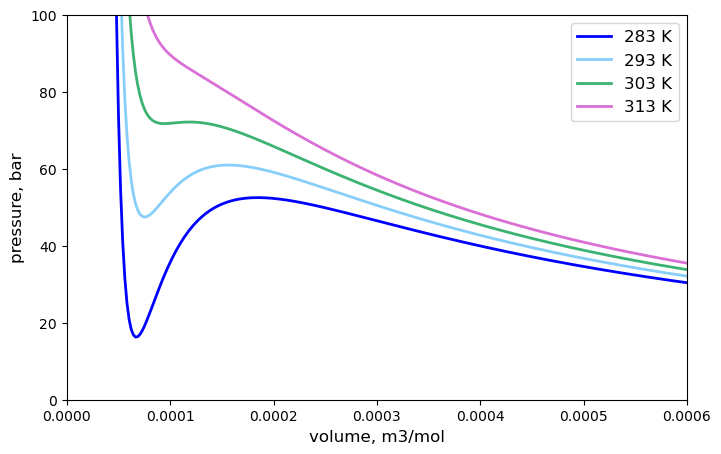

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dartsflash.dartsflash import DARTSFlash, CompData
from dartsflash.libflash import CubicEoS

# Define mixture and initialize Flash object
comp_data = CompData(components=["CO2"], setprops=True)
f = DARTSFlash(comp_data=comp_data)

# Add CubicEoS object
f.add_eos("CEOS", CubicEoS(comp_data, CubicEoS.PR))
ceos = f.eos["CEOS"]

# Define range of molar volumes for x-axis
Vmax = ceos.V(p=10, T=273.15, n=[1.])
Vmin = ceos.V(p=200, T=273.15, n=[1.])

# Define state specification, compositions and properties to evaluate
state_spec = {"volume": np.linspace(Vmin, Vmax, 1000),
              "temperature": np.array([283, 293, 303, 313]),
             }
compositions = {"CO2": 1.}
properties = {"P": ceos.P,
              "Z": ceos.Z,
             }

# Calculate pressure at each (V,T)
vt_props = f.evaluate_phase_properties_1p(state_spec=state_spec, compositions=compositions,
                                          properties_to_evaluate=properties, mole_fractions=True, print_state="VT props")

# Plot P-V diagram
from dartsflash.plot import PlotEoS
pv_plot = PlotEoS.pressure_volume(f, temperatures=state_spec["temperature"], compositions=[1.],
                                  p_props=None, v_props=vt_props, v_range=[0, 6e-4], p_range=[0, 100])

## 1.2. Compressibility factor Z
In order to calculate thermodynamic properties at a given (P,T), we have to solve for volume.

<img style = "float: left;" src = "slides/1d_Z.png" width = "80%">

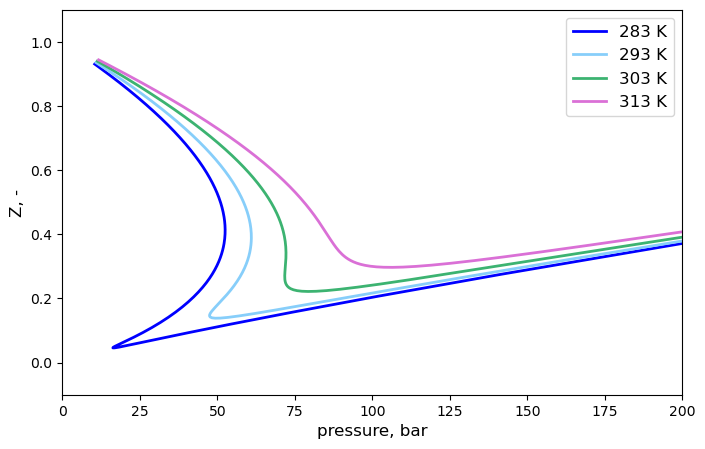

In [2]:
pz_plot = PlotEoS.compressibility(f, temperatures=state_spec["temperature"], compositions=[1.],
                                  p_props=None, v_props=vt_props, z_range=[-0.1, 1.1], p_range=[0, 200])

## 1.3. Solution of EoS
Now we can solve EoS to get roots
    
<img style = "float: left;" src = "slides/1h_vdW_solver.png" width = "80%">

[0.77822175 0.11575323 0.0720197 ]
5.6487345851761404e-05 0.0006103841103461916


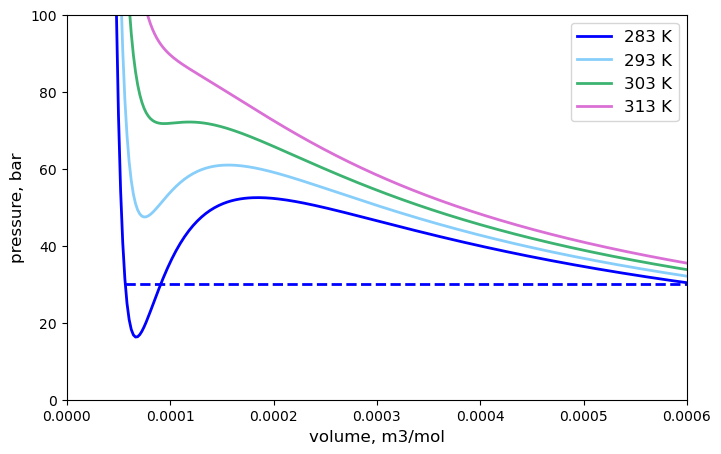

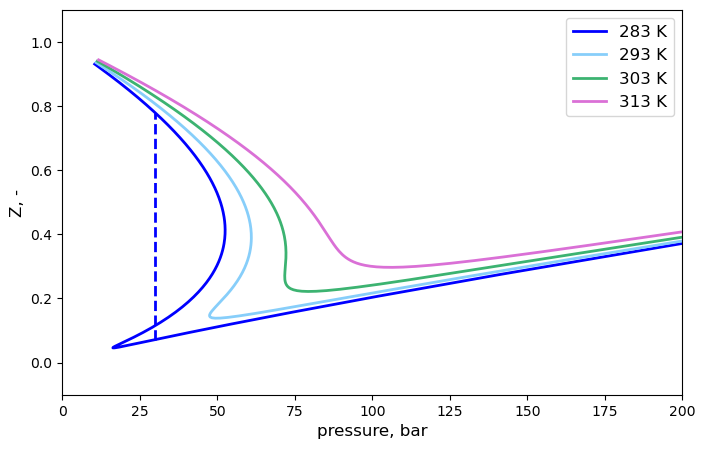

In [3]:
# Find the volume roots at given (P,T)
p, t = 30, 283

# calculate coefficients of cubic polynomial: a3 Z^3 + a2 Z^2 + a1 Z + a0 = 0
ai = ceos.calc_coefficients(p=p, T=t, n=[1.])  # a2, a1, a0
ai = np.append([1.], ai)  # add a3 coefficient
Z = np.roots(ai)
print(Z)

# Calculate min and max roots
Zmin, Zmax = np.amin(Z[np.imag(Z) == 0]), np.amax(Z[np.imag(Z) == 0])
R = 8.314472e-5  # m3.bar/mol.K
Vl, Vv = np.real(Zmin) * R * t / p, np.real(Zmax) * R * t / p
print(Vl, Vv)

# Plot P-V and P-Z diagrams
pv_plot = PlotEoS.pressure_volume(f, temperatures=state_spec["temperature"], compositions=[1.],
                                  p_props=None, v_props=vt_props, v_range=[0, 6e-4], p_range=[0, 100])
pv_plot.draw_line(X=[Vl, Vv], Y=[p, p], colours=pv_plot.colours[0], styles="dashed")

pz_plot = PlotEoS.compressibility(f, temperatures=state_spec["temperature"], compositions=[1.],
                                  p_props=None, v_props=vt_props, z_range=[-0.1, 1.1], p_range=[0, 200])
pz_plot.draw_line(X=[p, p], Y=[np.real(Zmin), np.real(Zmax)], colours=pv_plot.colours[0], styles="dashed")


## 1.4. Thermodynamic properties from an EoS
<img style = "float: left;" src = "slides/1e_fugacity.png" width = "80%">
<img style = "float: left;" src = "slides/1g_thermodynamic_props.png" width = "80%">

In [4]:
# Evaluate enthalpy and entropy of CO2
state_spec = {"temperature": np.arange(248, 348, 10),
              "pressure": np.array([25, 50, 75, 100]),
             }
compositions = {"CO2": 1.}
properties = {"H": ceos.H, "S": ceos.S}

results = f.evaluate_phase_properties_1p(state_spec=state_spec, compositions=compositions,
                                         properties_to_evaluate=properties, mole_fractions=True)


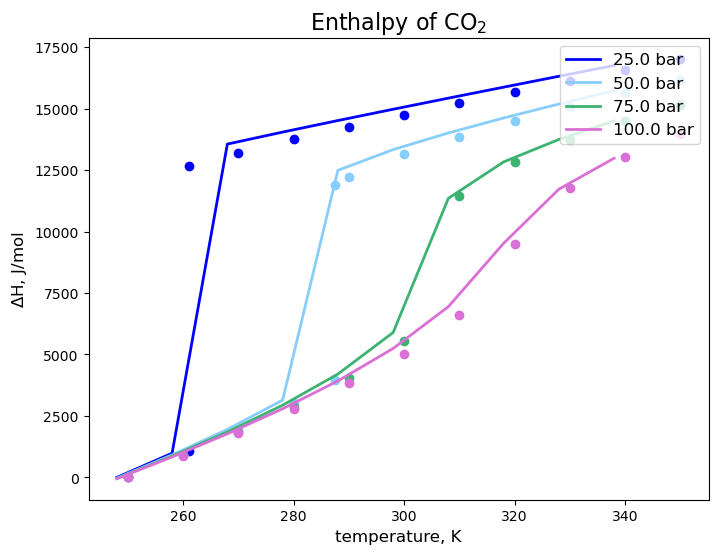

In [6]:
# Get NIST data and plot
from ref_data import get_nist_data

R = 8.3144772

num_curves = len(state_spec["pressure"])
ref_T, ref_H, ref_S = [np.ones(20) * np.nan for i in range(num_curves)], [np.ones(20) * np.nan for i in range(num_curves)], [np.ones(20) * np.nan for i in range(num_curves)]

for i, p in enumerate(state_spec["pressure"]):
    nist_data = get_nist_data(component="CO2", temperature=np.arange(250, 351, 10), pressure=p, include_phase_boundary=True)
    n_points = len(nist_data["temperature"])
    ref_T[i][:n_points] = nist_data["temperature"]
    ref_H[i][:n_points] = nist_data["enthalpy"]
    ref_S[i][:n_points] = nist_data["entropy"]

for i in range(num_curves):
    H0 = ref_H[i][0]
    ref_H[i][:] = [(Hj - H0) * 1e3 for Hj in ref_H[i][:]]  # set reference value of enthalpy and convert kJ/mol to J/mol
    S0 = ref_S[i][0]
    ref_S[i][:] = [(Sj - S0) * 1e3 for Sj in ref_S[i][:]]  # set reference value of entropy and convert kJ/mol to J/mol

T = state_spec["temperature"]
H0 = results.isel(pressure=0).H.values[0]  # set reference value of enthalpy at first value
H = [(results.isel(pressure=i).H.values - H0) * R for i, pres in enumerate(state_spec["pressure"])]
S0 = results.isel(pressure=0).S.values[0]  # set reference value of entropy at first value
S = [(results.isel(pressure=i).S.values - S0) * R * 1e3 for i, pres in enumerate(state_spec["pressure"])]
labels = ["{:.1f} bar".format(pres) for pres in state_spec["pressure"]]

from dartsflash.diagram import Diagram
H_plot = Diagram()
H_plot.draw_line(X=T, Y=H, datalabels=labels)
H_plot.draw_point(X=ref_T, Y=ref_H)
H_plot.add_attributes(title="Enthalpy of " + f.mixture_name, ax_labels=["temperature, K", r"$\Delta$H, J/mol"], legend=True)